-----------------------------------
Race: 6061944
Offer: Odds for Clipsham La Habana: 5.0
Stakes: 0.1619935392527373
Payout: -0.1619935392527373
-----------------------------------

0.3295948314021898
0.13404825737265416
2.458777442260336
-----------------------------------
Race: 6027489
Offer: Odds for Tango Boy: 3.45
Stakes: 0.18509518147998777
Payout: -0.18509518147998777
-----------------------------------

0.4212994767031797
0.16778523489932887
2.5109448811509507
-----------------------------------
Race: 5931854
Offer: Odds for Sopran Thor: 14.0
Stakes: 0.21939474677004858
Payout: -0.21939474677004858
-----------------------------------

0.27515226485790223
0.10638297872340426
2.586431289664281
-----------------------------------
Race: 6009206
Offer: Odds for Bobby On The Beat: 5.1
Stakes: 0.10510606900197121
Payout: -0.10510606900197121
-----------------------------------

0.2805754672368788
0.10638297872340426
2.637409392026661
-----------------------------------
Race: 6048131
O

<AxesSubplot:>

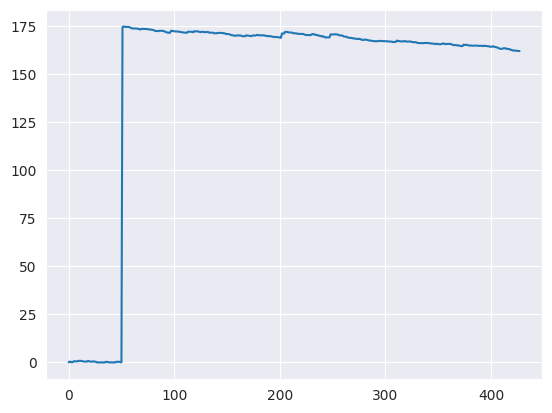

In [19]:
import pickle
import seaborn as sns
from numpy import cumsum

TEST_BETS_PATH = "../data/test_payouts.dat"

with open(TEST_BETS_PATH, "rb") as f:
    test_bets = pickle.load(f)
    
test_bets = [bet for bet in test_bets if bet.probability_estimate > 0.25]
# test_bets = [bet for bet in test_bets if bet.race_card.category == "HCP"]
test_bets_with_sp = [bet for bet in test_bets if bet.probability_start > -1]
sorted_bets = sorted(test_bets_with_sp, key=lambda bet: bet.probability_estimate / bet.probability_start)

worst_bets = sorted_bets[-30:]

for bet in worst_bets:
    print(bet)
    print(bet.probability_estimate)
    print(bet.probability_start)
    print(bet.probability_estimate / bet.probability_start)

payout_values = [bet.payout for bet in test_bets]
x = [i for i in range(len(payout_values))]
cum_payout_values = cumsum(payout_values)
sns.lineplot(x=x, y=cum_payout_values)

## Displaying payouts per race category

{'HCP': 0.0063675204374354245}
{'HCP': 12199}


<AxesSubplot:>

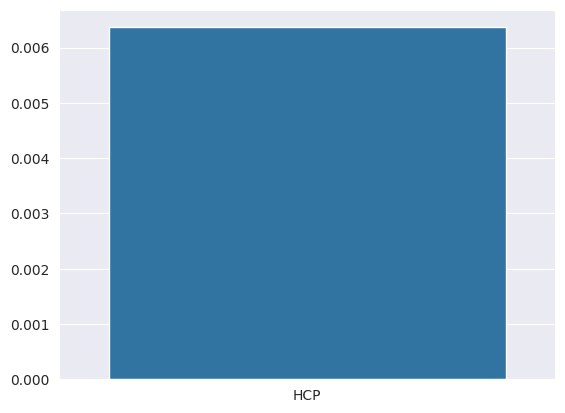

In [15]:
from Model.Betting.bet import Bet
from typing import List
import numpy as np

def get_payouts_per_category(bets: List[Bet], category: str):
    payouts = {}
    
    for bet in bets:
        cat = bet.race_card.__getattribute__(category)
        if cat not in payouts:
            payouts[cat] = []
            
        payouts[cat].append(bet.payout)
        
    return payouts
    
payouts_per_category = get_payouts_per_category(test_bets, "category")

payout_means = {}
payout_counts = {}

for race_category in payouts_per_category:
    payout_means[race_category] = np.mean(payouts_per_category[race_category])
    payout_counts[race_category] = len(payouts_per_category[race_category])

print(payout_means)
print(payout_counts)
sns.barplot(x=list(payout_means.keys()), y=list(payout_means.values()))

{'low': 0.8264946719362226, 'mid': 22.122657232044006, 'high': 54.72822991229458}
{'low': 527, 'mid': 7536, 'high': 4136}


<AxesSubplot:>

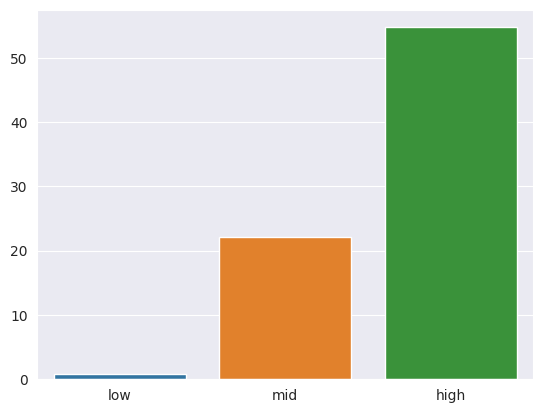

In [16]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets:
    odds = bet.bet_offer.odds
    
    odds_category = "low"
    if 5 <= odds <= 20:
        odds_category = "mid"
    if 20 < odds:
        odds_category = "high"
        
    payouts[odds_category].append(bet.payout)

payout_sums = {"low": 0, "mid": 0, "high": 0}
payout_counts = {"low": 0, "mid": 0, "high": 0}

for odds_category in payouts:
    payout_sums[odds_category] = np.sum(payouts[odds_category])
    payout_counts[odds_category] = len(payouts[odds_category])
    
print(payout_sums)
print(payout_counts)
    
sns.barplot(x=list(payout_sums.keys()), y=list(payout_sums.values()))

{'low': -0.0026278627261914454, 'mid': -0.007556261587166166, 'high': 0.378503034643022}
{'low': 938, 'mid': 10833, 'high': 428}


<AxesSubplot:>

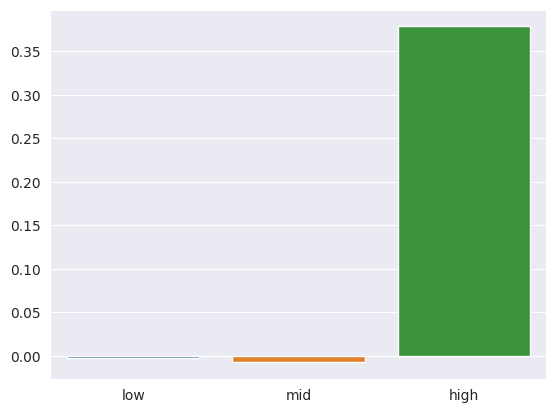

In [17]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets:
    prob_estimate = bet.probability_estimate

    prob_estimate_category = "low"
    if 0.05 <= prob_estimate <= 0.25:
        prob_estimate_category = "mid"
    if 0.25 < prob_estimate:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

{'low': 0.006794559053825979, 'mid': 0.0045970958945564, 'high': 8.670919514309797e-05}
{'low': 10323, 'mid': 1635, 'high': 241}


<AxesSubplot:>

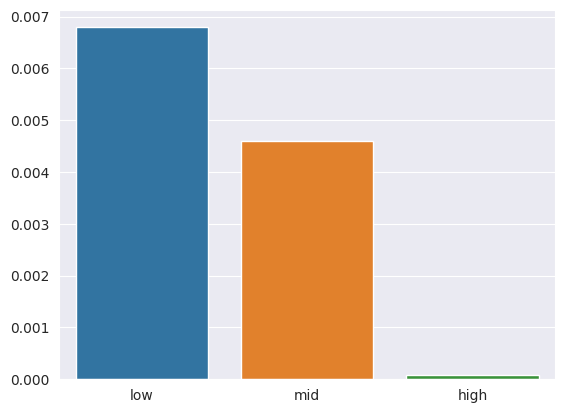

In [18]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets:
    prob_estimate = bet.bet_offer.adjustment_factor

    prob_estimate_category = "low"
    if 0.7 <= prob_estimate <= 0.9:
        prob_estimate_category = "mid"
    if prob_estimate < 0.7:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

<AxesSubplot:ylabel='Count'>

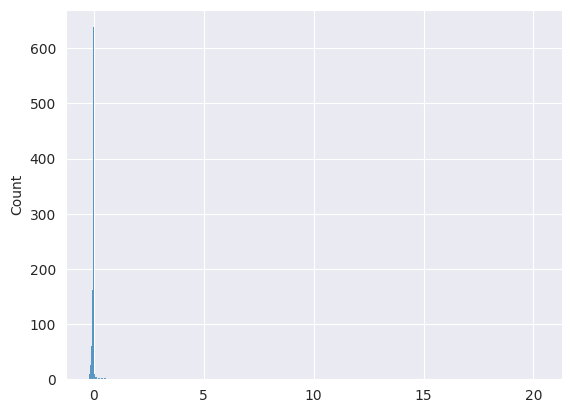

In [38]:
sns.histplot(payouts["mid"])

In [2]:
import sys
sys.path.append('/home/daniel/PycharmProjects/WageringSystem')

from Experiments.FundHistorySummary import FundHistorySummary
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 1000
    bet_limit_fraction = 0.5
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=1000)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    snapshots = fund_history_summary.snapshots
    dates = [snapshot.date.split()[0] for snapshot in snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

<AxesSubplot:>

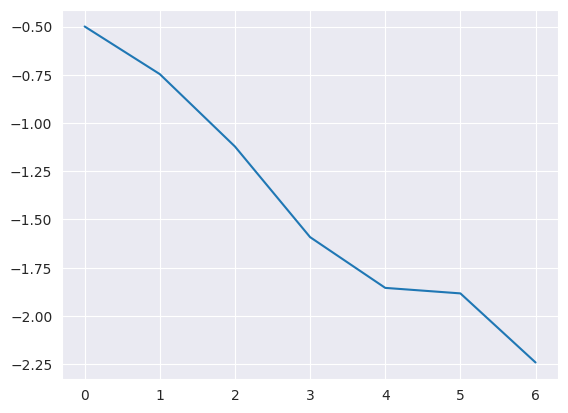

bet rate: 0.4521651560926485
max losses: 0.4877224369010293
min:-0.40205780052305334
max:0.8104727595202854
avg:-0.0006941577404636012
mid count: 446
high count: 404
low count: 48
{'mid': -1.3173410192776493, 'high': -0.6234185520626283, 'low': 0.5621622987795668}


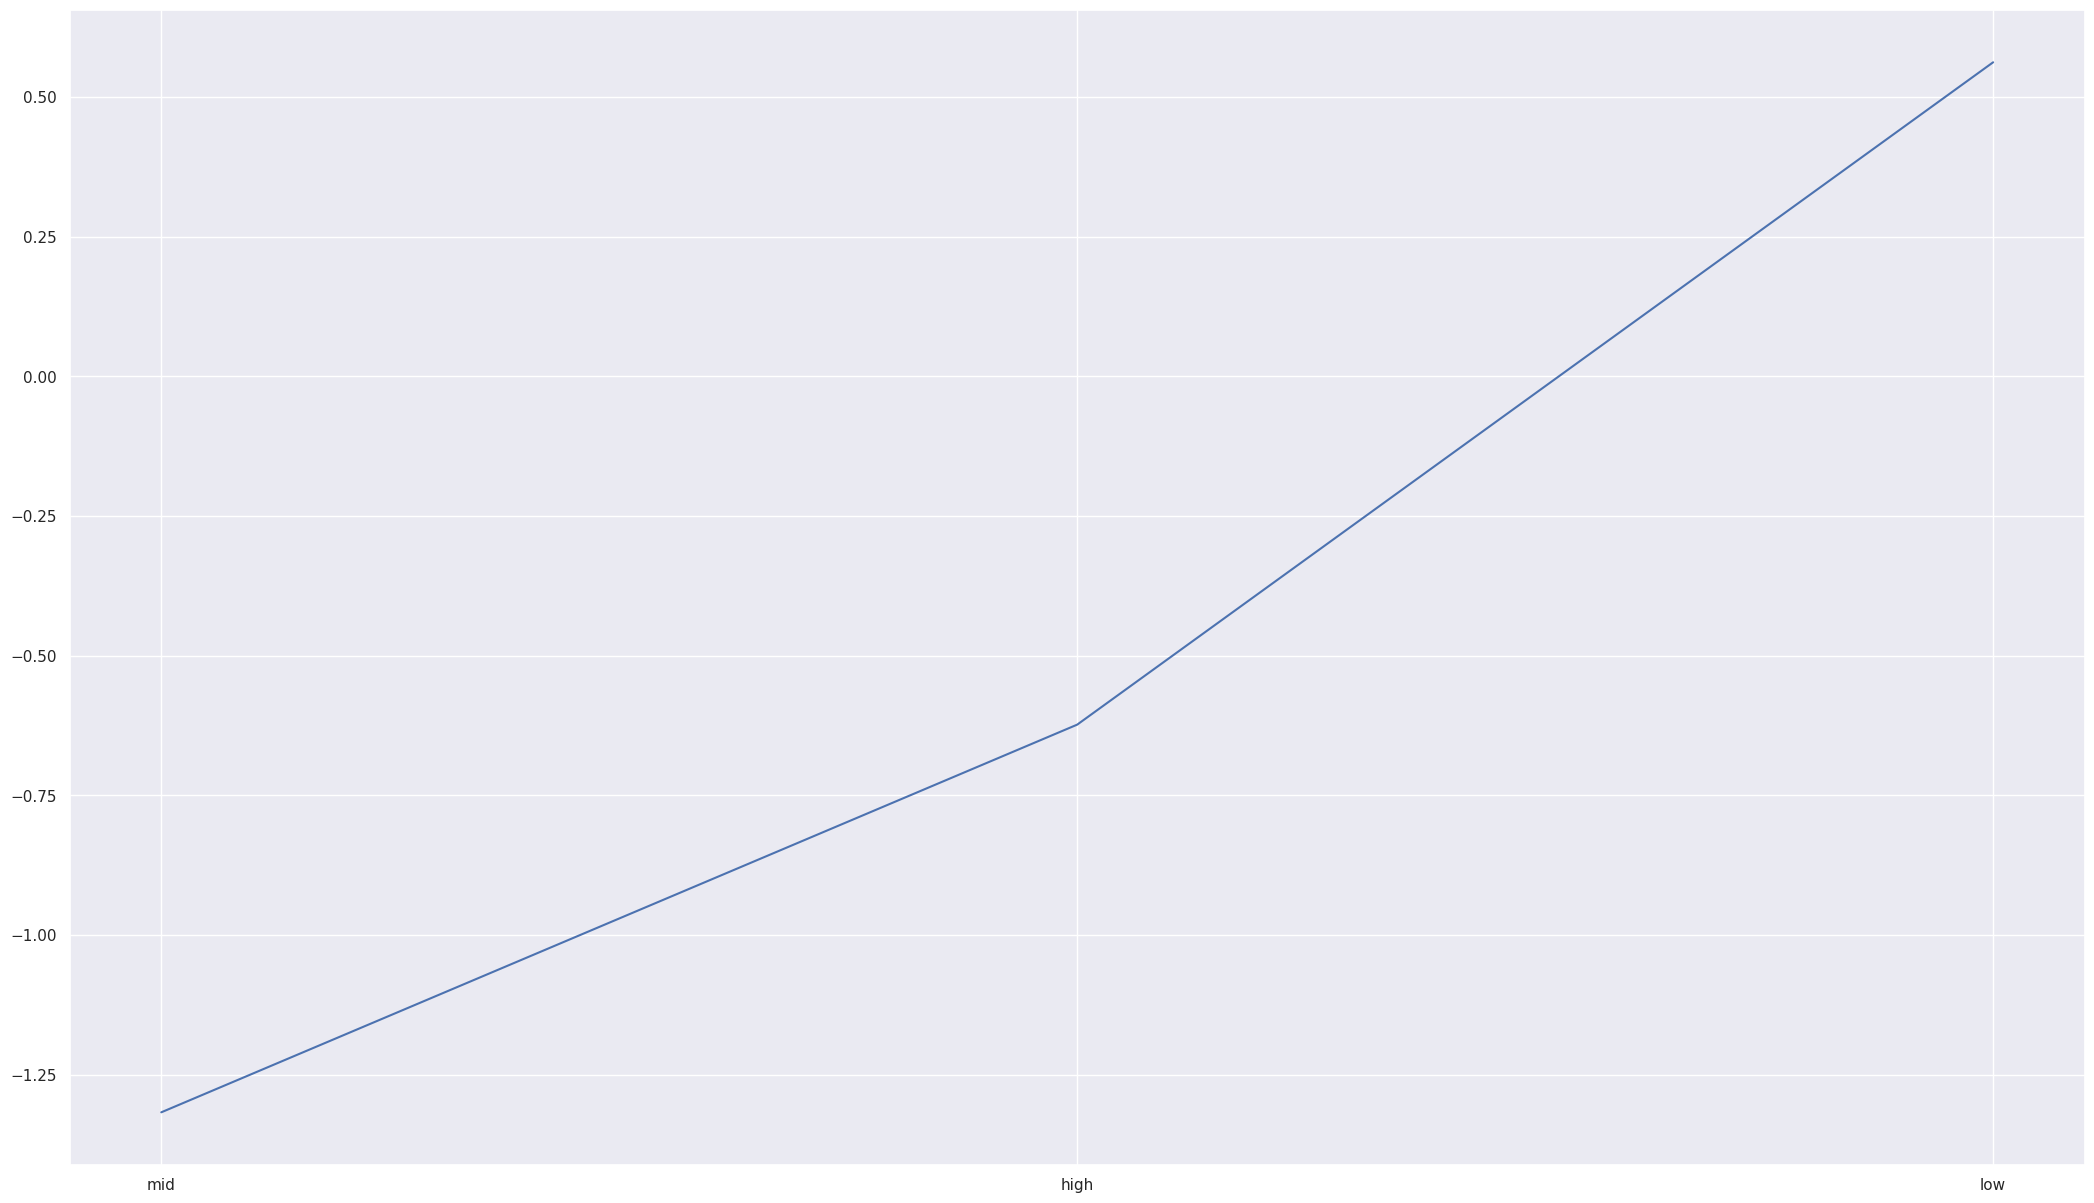

In [15]:
from numpy import average, mean

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")

payout_bet_count_dist = {}
payout_n_horses_dist = {}

for betting_slip in fund_history_summary.betting_slips.values():
    odds = 0
    if betting_slip.bets:
        for bet in betting_slip.bets:
            if bet.stakes_fraction > 0:
                odds = bet.odds

                odds_category = "low"
                if 2 <= odds <= 4:
                    odds_category = "mid"
                if 4 < odds:
                    odds_category = "high"
                if odds_category not in payout_bet_count_dist:
                    payout_bet_count_dist[odds_category] = {"total": bet.win - bet.loss, "n": 1}
                else:
                    payout_bet_count_dist[odds_category]["total"] += bet.win - bet.loss
                    payout_bet_count_dist[odds_category]["n"] += 1

        n_horses_category = len(betting_slip.bets)

        if n_horses_category not in payout_n_horses_dist:
            payout_n_horses_dist[n_horses_category] = 0

        payout_n_horses_dist[n_horses_category] += betting_slip.payout_percentage

for key in payout_bet_count_dist:
    if "total" in payout_bet_count_dist[key]:
        print(f"{key} count: {payout_bet_count_dist[key]['n']}")
        payout_bet_count_dist[key] = payout_bet_count_dist[key]["total"]

print(payout_bet_count_dist)
ax = sns.lineplot(data=payout_bet_count_dist)

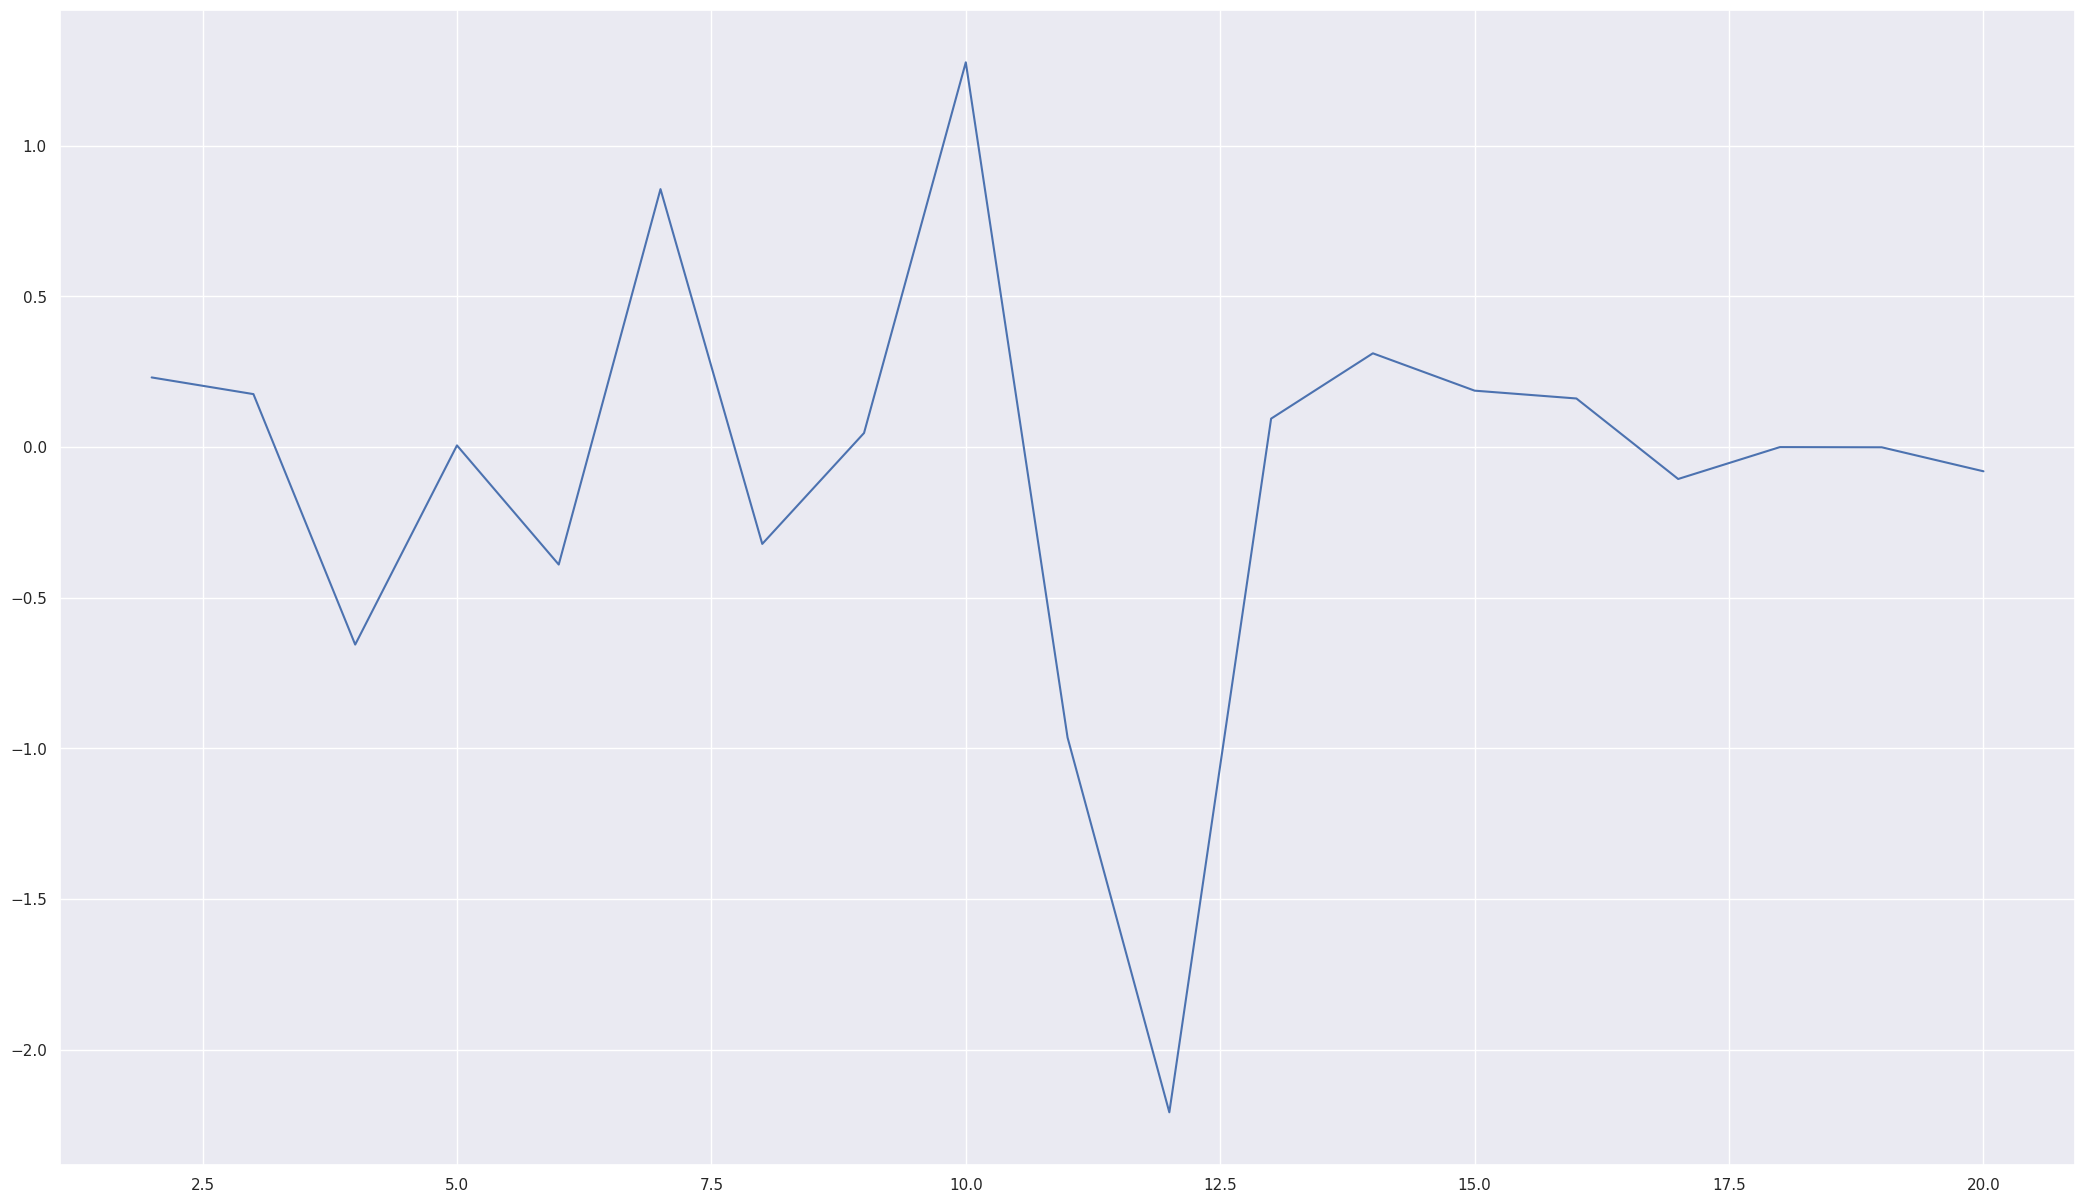

In [16]:
ax2 = sns.lineplot(data=payout_n_horses_dist)

In [18]:
sorted_betting_slips = sorted(fund_history_summary.betting_slips.values(), key=lambda x: x.payout_percentage, reverse=True)

for betting_slip in sorted_betting_slips:
    if betting_slip.race_id == 5377715:
        print(betting_slip)

worst_betting_slips = sorted_betting_slips[-1:]

for betting_slip in worst_betting_slips:
    print(betting_slip)
    print(f"https://www.racebets.de/de/pferdewetten/race/details/id/{betting_slip.race_id}/")

Betting slip:
(Fractional) total loss: 0.40205780052305334
Bets:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Win bet:
---------------------------------------
Horse number: 3
Odds of horse: 13.5
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.022303406551620455
---------------------------------------
Win bet:
---------------------------------------
Horse number: 12
Odds of horse: 42.0
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.019949800366359315
---------------------------------------
Win bet:
---------------------------------------
Horse number: 11
Odds of horse: 12.51
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.04289678707224094
---------------------------------------
Win bet:
---------------------------------------
Horse number: 10
Odds of horse: 42.0
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.011537181551187211
---------------------------------------


<AxesSubplot:>

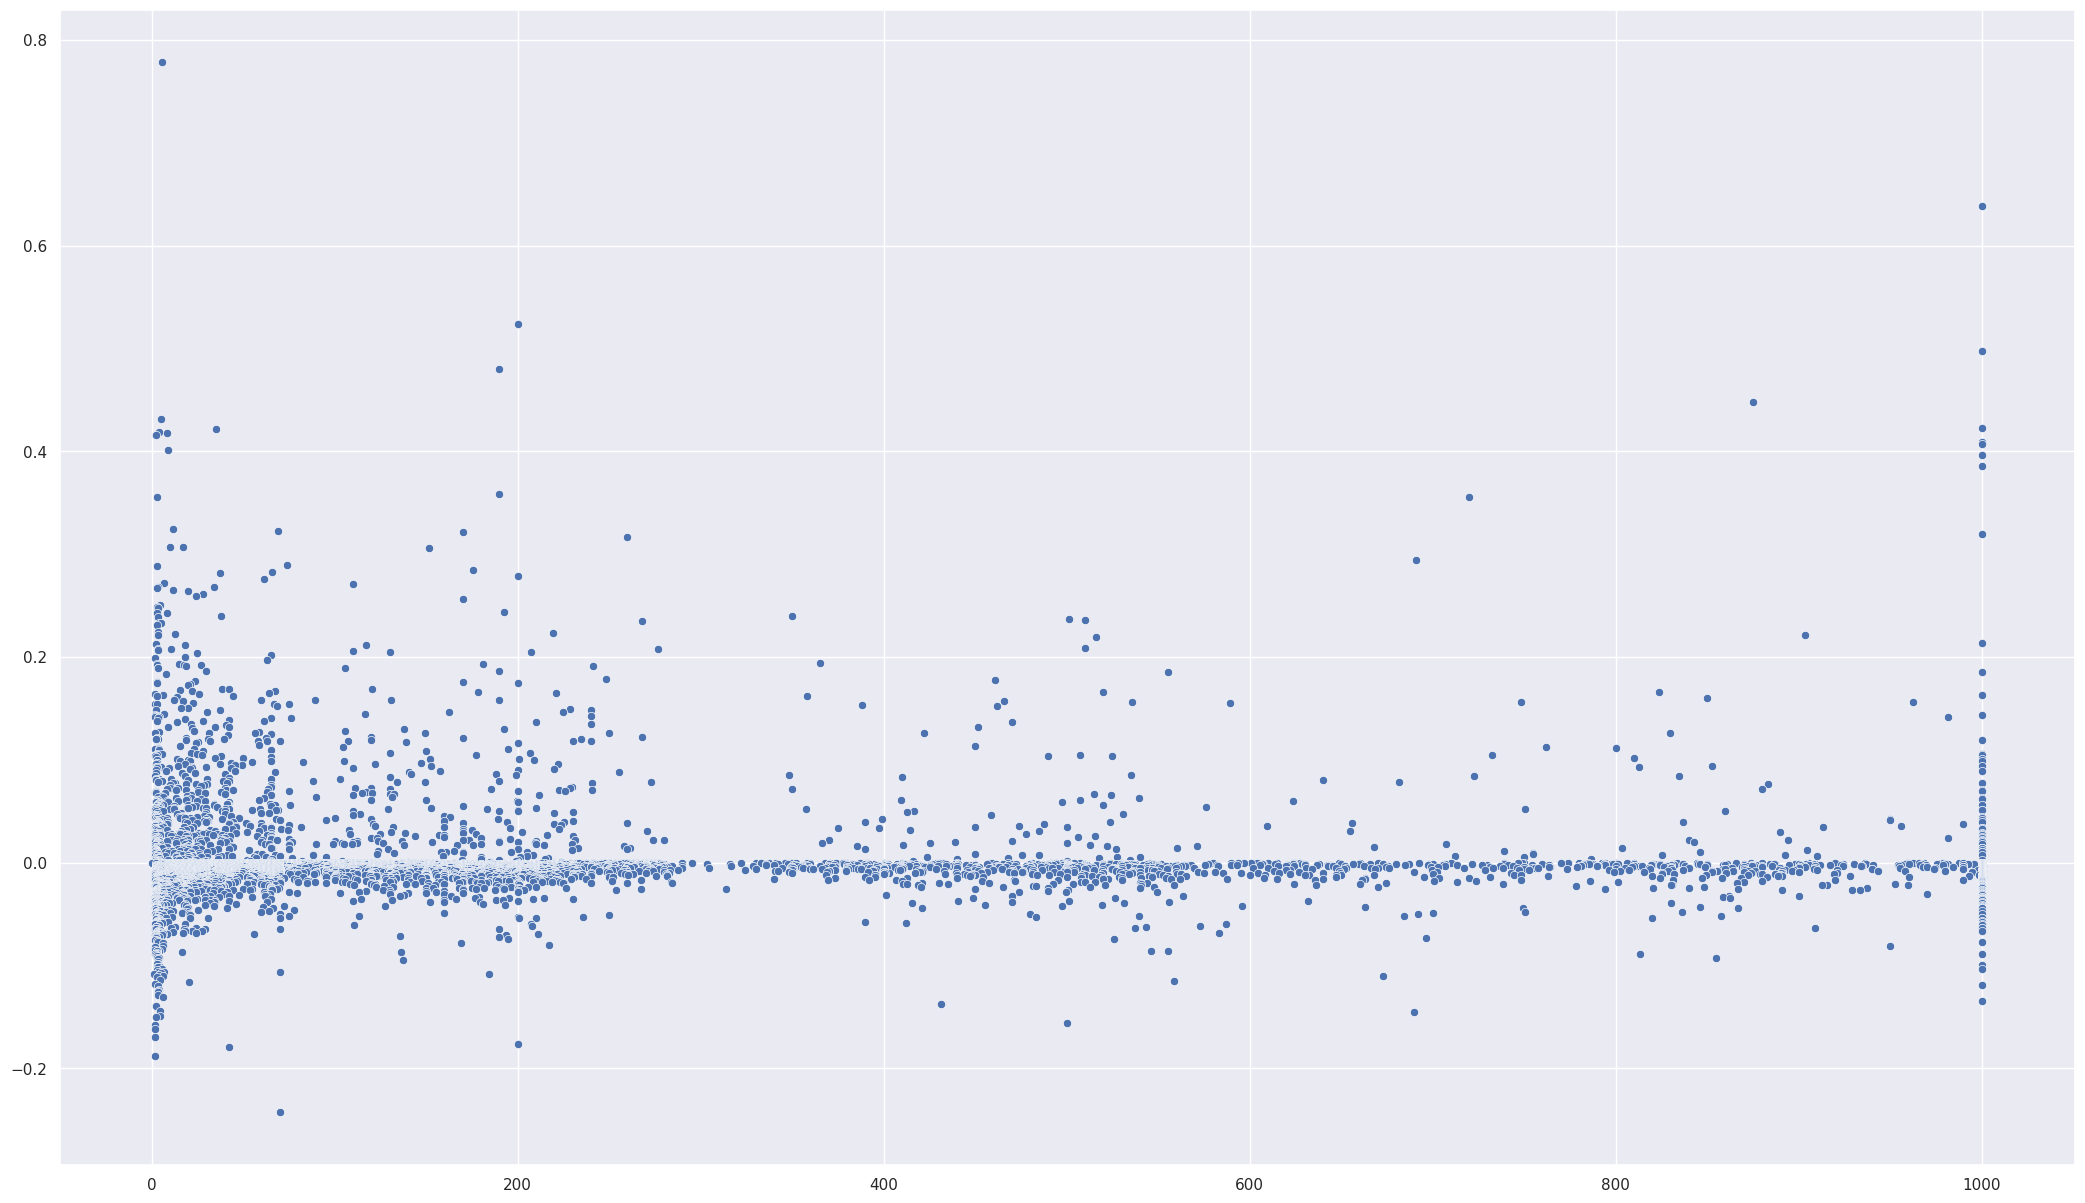

In [24]:
payout_percentages = [betting_slip.payout_percentage for betting_slip in sorted_betting_slips]
odds = []
for betting_slip in sorted_betting_slips:
    if betting_slip.bets:
        odds.append(betting_slip.bets[0].predicted_horse_results[0].betting_odds)
    else:
        odds.append(0)

sns.scatterplot(x=odds, y=payout_percentages)

## Real payout plotting

12.333333333333343


Text(0, 0.5, 'Wealth change in %')

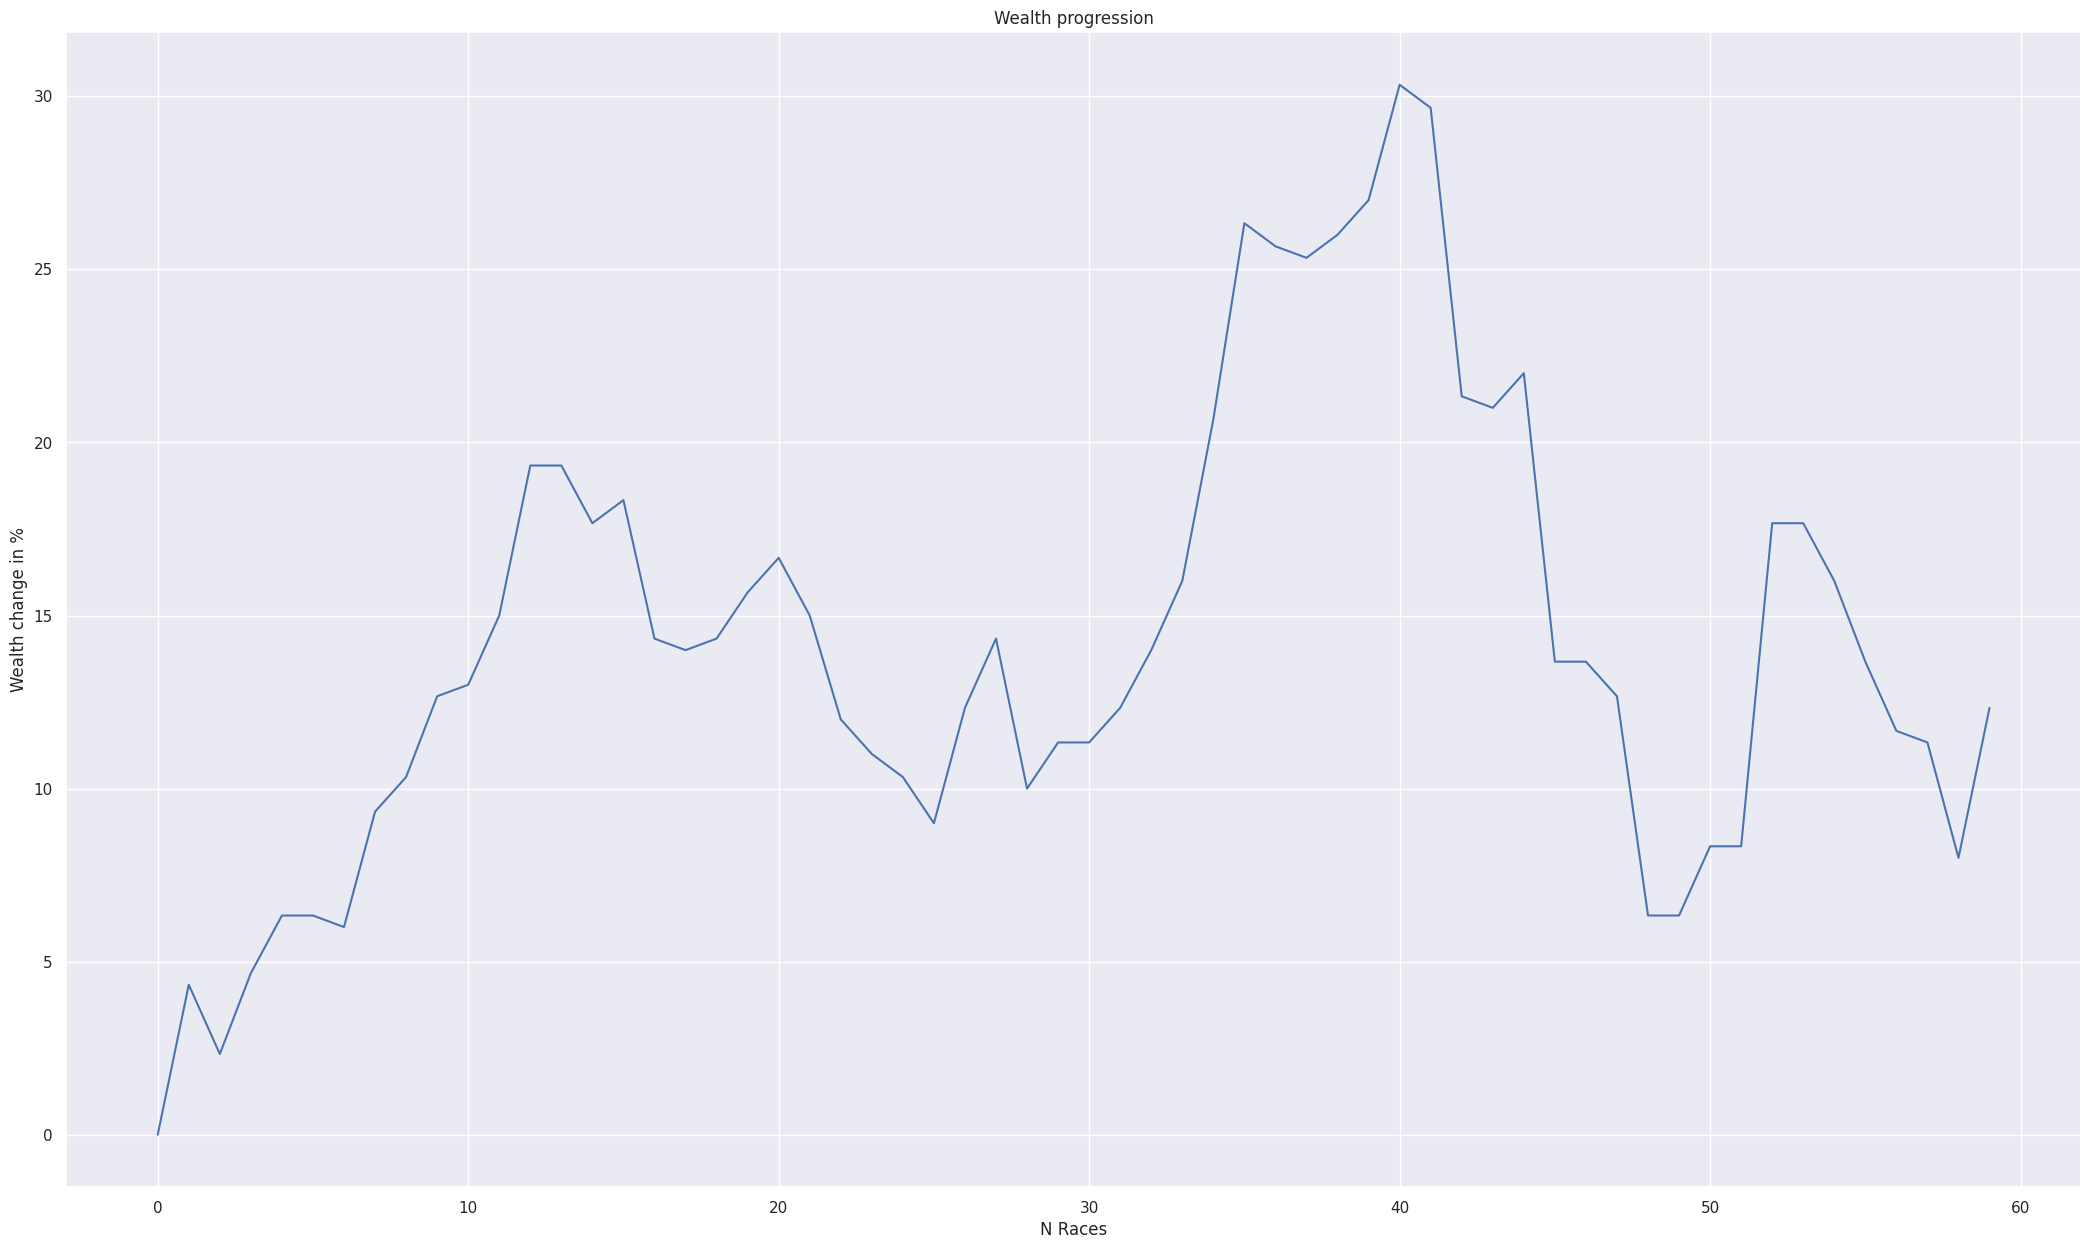

In [25]:
from numpy import cumsum
import seaborn as sns
real_payouts = [
    0, 13, -6, 7, 5, 0, -1, 10, 3, 7, 1, 6, 13, 0, -5, 2, -12,
    -1, 1,
    4, 3, -5, -9, -3, -2, -4, 10, 6, -13, 4, 0, 3,
    5, 6, 14, 17, -2, -1, 2, 3, 10, -2,
    -25, -1, 3, -25, 0, -3, -19, 0, 6, 0, 28, 0, -5, -7, -6, -1, -10, 13,
]

real_payouts = [real_payout / 3 for real_payout in real_payouts]

print(cumsum(real_payouts)[-1])

ax = sns.lineplot(cumsum(real_payouts))
ax.set_title("Wealth progression")
ax.set_xlabel("N Races")
ax.set_ylabel("Wealth change in %")

In [10]:
import pandas as pd

# Create a sample dataframe with three columns 'A', 'B', and 'C'
df = pd.DataFrame({'A': [1, 1, 1, 2, 2, 2, 2, 2],
                   'B': [2, 3, 5, 10, 20, 55, 65, 75],
                   'C': [2, 2, 2, 3, 3, 3, 3, 3]})

# Group the dataframe by column 'A' and get the values of 'B' and 'C' for each group
grouped = df.groupby('A')[['B', 'C']].agg({'B': lambda x: list(x), 'C': 'first'})

# Convert the grouped values to a list of tuples
result = [tuple(row) for row in grouped.values]

print(result)

[([2, 3, 5], 2), ([10, 20, 55, 65, 75], 3)]


In [29]:
import pickle

BET_MODEL_CONFIGURATION_PATH = "../data/bet_model_configuration.dat"

with open(BET_MODEL_CONFIGURATION_PATH, "rb") as f:
    bet_model_configuration = pickle.load(f)

print([feature.get_name() for feature in bet_model_configuration.feature_subset])

['BetfairWinMarketWinProbability', 'PreviousRelativeDistanceBehind', 'PreviousSlowerThanNumber', 'IndustryMarketWinProbabilityDiff', 'CurrentSpeedFigure', 'Gender', 'MinutesIntoDay', 'CurrentDistance', 'HasFallen', 'HasTrackChanged', 'HasTrainerMultipleHorses', 'WeekDayCos', 'CurrentRaceClass', 'CurrentGoing', 'CurrentRaceType', 'CurrentRaceCategory', 'AgeFrom', 'HasBlinkers', 'HasVisor', 'HasHood', 'HasCheekPieces', 'HasEyeCovers', 'HasTongueStrap', 'AbsoluteTime', 'TwoYearStartCount', 'HasFewStartsInTwoYears', 'JockeyWinRate', 'BreederWinRate', 'DamSireWinRate', 'HorseTrainerWinRate', 'JockeyTrackWinRate', 'JockeyClassWinRate', 'TrainerSurfaceWinRate', 'TrainerTrackWinRate', 'HorseShowRate', 'SireShowRate', 'DamSireShowRate', 'HorseBreederShowRate', 'JockeyTrackShowRate', 'TrainerSurfaceShowRate', 'TrainerTrackShowRate', 'HorsePurseRate', 'JockeyPurseRate', 'OwnerPurseRate', 'DamPurseRate', 'DamSirePurseRate', 'HorseJockeyPurseRate', 'HorseBreederPurseRate', 'JockeyDistancePurseRate'

100